# Fitting Pendulum for Spring and Damping Constant
Fuchen Chen 
2021/03/16

In [122]:
%matplotlib inline

import pynamics
from pynamics.frame import Frame
from pynamics.variable_types import Differentiable,Constant
from pynamics.system import System
from pynamics.constraint import Constraint
from pynamics.dyadic import Dyadic
from pynamics.output import PointsOutput
from pynamics.particle import Particle
from pynamics.body import Body
import pynamics.integration

import sympy
import numpy as np
import scipy.optimize
import matplotlib.pyplot as plt
from math import pi

from IPython.display import display, clear_output
import time
import csv
import logging

In [123]:
DEG_TO_RAD = pi/180

# Unit scaling
M_TO_L = 1e3 # mm
KG_TO_W = 1e3 # g
S_TO_T = 1e0 # 1s

## Experiment
Two links are 3D printed to sandwich the flexible material and form a single pendulum. Markers are painted on the side of the link for tracking. It is then fixed onto a box and one end is released from about horizontal location. The motion is captured using iPhone 6s 240fps slow motion mode. A screenshot of the captured video is shown below. Tracker is then used to extract the motion data from the video. The y axis is point upward and x axis pointing right along the upper edge of the box.

Minimum angle in degrees -123.29512038879535


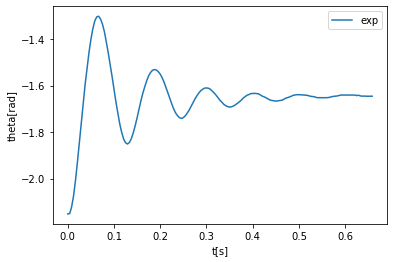

In [124]:
# Experimental Data
t_exp = []
x_exp = []
y_exp = []
with open('polyurethane foam left.csv', newline='') as data_file:
    reader = csv.reader(data_file)
    for i, row in enumerate(reader):
        if i < 2: continue
            
        t_exp.append(float(row[0]))
        x_exp.append(float(row[1]))
        y_exp.append(float(row[2]))

# Fit a smaller range because the final robot joint will not have a big range of motion. 
i_start = 32 
t_exp = np.array(t_exp)[i_start:]
t_exp = t_exp-np.amin(t_exp)
x_exp = np.array(x_exp)[i_start:]
y_exp = np.array(y_exp)[i_start:]
theta_exp = np.arctan2(y_exp, x_exp)
print('Minimum angle in degrees', np.amin(theta_exp)/DEG_TO_RAD)

plt.figure()
plt.plot(t_exp, theta_exp, label='exp')
plt.xlabel('t[s]')
plt.ylabel('theta[rad]')
plt.legend()    

## Simulation
The model of the experiment is simulated in pynamics. There are only two unknowns for the model, damping and spring constants. Some arbitary values are chosen first to validate the correctness of the simulation and also served as the inital guesses for the optimization. As shown in the figure below, the experiment and simulation motion are similar. To be noted, the simulation initial angle are set to the experiment value and velocity is assumed zero. The spring resting angle is set to the final angle of the link. For joint made of polyurethane foam, the link can not return to the flat state(-90 degrees) with only gravity within 30 seconds after release. It does become flat if an external force is exerted. This behavior might be related to the properties of this specific material. 
![setup](./data/experiment-setup.jpg)

In [131]:
# Simulation values
fps = 200
tfinal = t_exp[-1]*S_TO_T # Same duration as experiment
tol = 1e-9

q_i = np.arctan2(y_exp[0],x_exp[0]) # Initial value from experiment
# q_k = -90*DEG_TO_RAD 
q_k = np.arctan2(y_exp[-1],x_exp[-1]) # spring rest angle from experiment

mass = 0.0025*KG_TO_W

mass_offset = 0.003*M_TO_L
length = 0.02*M_TO_L
width = 0.035*M_TO_L
thickness = 0.0045*M_TO_L

gravity = 9.81*M_TO_L/S_TO_T**2  # Gravity m/s^2

damping = 1e-5*KG_TO_W*M_TO_L**2/S_TO_T # angular damping, kg*m/s^2*m/(rad/s)
spring = 5e-4*KG_TO_W*M_TO_L**2/S_TO_T**2 # angular spring constant, kg*m/s^2*m/rad

In [132]:
system = System()
pynamics.set_system(__name__,system)

# Constants
l = Constant(length,'l',system)
lm = Constant(length/2+mass_offset,'lm',system)
m = Constant(mass,'m',system)

g = Constant(gravity,'g',system)

b = Constant(damping,'b',system)
k = Constant(spring,'k',system)

# Variables
q,q_d,q_dd = Differentiable('q',system)

state_variables = system.get_state_variables()

# Frames
N = Frame('N')
A = Frame('A')

system.set_newtonian(N)

In [133]:
# Kinemactics
A.rotate_fixed_axis_directed(N,[0,0,1],q,system)

pNA = 0*N.x+0*N.y # Joint
pNB = pNA+l*A.x # Marker

pm = pNA+lm*A.x # Center of mass

In [134]:
# Dynamics
Ixx = Constant(mass*(width**2+thickness**2)/12, 'Ixx', system)
Iyy = Constant(mass*(length**2+width**2)/12, 'Iyy', system)
Izz = Constant(mass*(length**2+thickness**2)/12, 'Izz', system)
I = Dyadic.build(A,Ixx,Iyy,Izz)
Link = Body('Link',A,pm,m,I,system)

# Spring and damping force
NwA = N.getw_(A)
system.addforce(-b*NwA,NwA)
system.add_spring_force1(k,(q-q_k)*N.z,NwA)

# Gravity
system.addforcegravity(-g*N.y)

In [129]:
# Simulation
t_sim = np.linspace(0,tfinal,int(tfinal/(1/fps)))
states_init = [q_i, 0]
x0 = np.array([damping,spring])

def sim(x):
    # Use provided spring and damping coeff
    cs = system.constant_values.copy()
    cs[b] = x[0]
    cs[k] = x[1]
    
    # Run simulation
    f,ma = system.getdynamics()
    f_s, f_c = system.state_space_post_invert(f,ma,[],return_lambda=True)
    states = pynamics.integration.integrate(f_s,states_init,t_sim,rtol=tol,atol=tol, args=({'constants':cs},))

    points_output = PointsOutput([pNA,pNB],system)
    outputs = points_output.calc(states)    
    outputs_shaped = outputs.reshape((outputs.shape[0],-1)) # [[Ax, Ay, Bx, By]...]
    
    x_sim = outputs_shaped[:,2]
    y_sim = outputs_shaped[:,3]
    theta_sim = np.arctan2(y_sim, x_sim)

    return x_sim, y_sim, theta_sim, outputs

# Plot 
def plot(x_sim, y_sim, theta_sim):
    plt.figure()
    plt.plot(t_sim, theta_sim, label='sim')
    plt.plot(t_exp, theta_exp, label='exp')
    plt.xlabel('t[s]')
    plt.ylabel('theta[rad]')
    plt.legend()    
    
#     plt.figure()
#     plt.plot(t_sim, x_sim, label='sim')
#     plt.plot(t_exp, x_exp, label='exp')
#     plt.xlabel('t[s]')
#     plt.ylabel('x[mm]')
#     plt.legend()

#     plt.figure()
#     plt.plot(t_sim, y_sim, label='sim')
#     plt.plot(t_exp, y_exp, label='exp')
#     plt.xlabel('t[s]')
#     plt.ylabel('y[mm]')
#     plt.legend()
#     plt.show()

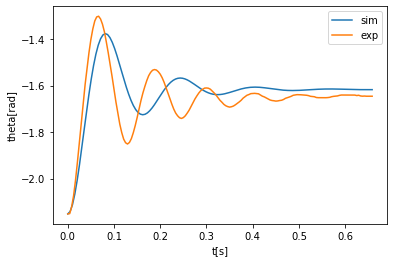

In [130]:
x_sim, y_sim, theta_sim, outputs = sim(x0)
plot(x_sim, y_sim, theta_sim)

## Optimization
To find the spring and damping constants that match the experiment the best, an objetive function is formulated. A scaling factor is used to improve the numerical perfromance. After optimization, the damping constant found is 8e-6 kg*m/s^2*m/(rad/s). The spring constant is 1e-3 kg*m/s^2*m/rad. As shown in the figure below, these values can only match the first two cycles reasonably well. The latter discrepancy may be caused by the fact that such joint made of polyurethane foam does not have a constant damping and spring coefficients. There can also exist some other material properties that are not modelled here. 

In [136]:
scaling = 1e4

# Optimize
def obj(x):
    x_sim, y_sim, theta_sim, outputs = sim(x*scaling)
    
    theta_sim = np.interp(t_exp,t_sim,theta_sim)
    
    error = np.average((theta_sim-theta_exp)**2)**0.5

    return error

x0_scaled = x0/scaling
# print(x0_scaled, obj(x0_scaled))

In [137]:
logger = logging.getLogger() # Disable logging
logging.disable(logging.CRITICAL)

res = scipy.optimize.differential_evolution(
    obj,
    [
        (x0_scaled[0]/10,x0_scaled[0]*10), # Range
        (x0_scaled[1]/10,x0_scaled[1]*10),
    ],
    disp=True
)
print(res)
xopt_scaled = res.x

differential_evolution step 1: f(x)= 0.0388828
differential_evolution step 2: f(x)= 0.034593
differential_evolution step 3: f(x)= 0.0345281
differential_evolution step 4: f(x)= 0.0334027
differential_evolution step 5: f(x)= 0.0334027
differential_evolution step 6: f(x)= 0.0297731
differential_evolution step 7: f(x)= 0.0297731
differential_evolution step 8: f(x)= 0.0297731
differential_evolution step 9: f(x)= 0.0297731
differential_evolution step 10: f(x)= 0.0297731
differential_evolution step 11: f(x)= 0.0297457
differential_evolution step 12: f(x)= 0.0297457
differential_evolution step 13: f(x)= 0.0297457
differential_evolution step 14: f(x)= 0.0297457
     fun: 0.029745674956461056
     jac: array([ 0.03510259, -0.01221988])
 message: 'Optimization terminated successfully.'
    nfev: 477
     nit: 14
 success: True
       x: array([ 0.82318384, 99.3088216 ])


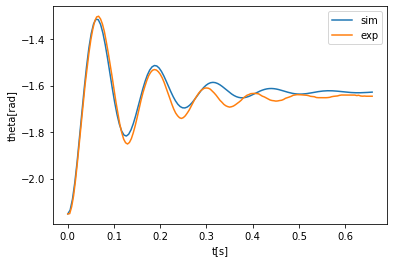

In [138]:
xopt = xopt_scaled*scaling
x_sim, y_sim, theta_sim, outputs = sim(xopt)
plot(x_sim, y_sim, theta_sim)
# print(x0, xopt)

In [114]:
# # Animate
# fig = plt.figure()
# for pts in outputs:
#     plt.cla()
    
#     plt.plot(pts[:,0],pts[:,1])
#     plt.axis('scaled')
#     plt.xlim(-0.02*M_TO_L,0.02*M_TO_L)
#     plt.ylim(-0.03*M_TO_L,0.0*M_TO_L)   
    
#     display(fig)
#     clear_output(wait=True)
# #     time.sleep(1/fps)   

In [139]:
damping_opt = xopt[0]/KG_TO_W/M_TO_L**2*S_TO_T
spring_opt = xopt[1]/KG_TO_W/M_TO_L**2*S_TO_T**2
print('Damping constant', damping_opt)
print('Spring constant', spring_opt)

Damping constant 8.231838442707815e-06
Spring constant 0.000993088216017184
